<a href="https://colab.research.google.com/github/jat1667/SML312-cog-age/blob/main/SML312_cog_age_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing and EDA for NCPT

In [ ]:
!pip install numpy pandas seaborn statsmodels matplotlib
!pip install --no-deps git+https://github.com/pauljaffe/lumos-ncpt-tools.git

  Cloning https://github.com/pauljaffe/lumos-ncpt-tools.git to /tmp/pip-req-build-bwa01j00
  Running command git clone --filter=blob:none --quiet https://github.com/pauljaffe/lumos-ncpt-tools.git /tmp/pip-req-build-bwa01j00
  Resolved https://github.com/pauljaffe/lumos-ncpt-tools.git to commit 5cbcdabef53146e64224299688f07de1054ebdd2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import lumos_ncpt_tools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lumos_ncpt_tools.ncpt import NCPT
from lumos_ncpt_tools.utils import load_data

df = pd.read_csv("/content/battery50_df.csv")


ncpt = NCPT(df)
del df

The following section directly follows suggestions from the NCPT github for preprocessing and outlier removal

Subtest ID 29: N outliers = 918
Subtest ID 45: N outliers = 4858
Subtest ID 43: N outliers = 156
Subtest ID 44: N outliers = 85
Subtest ID 39: N outliers = 11563
Subtest ID 40: N outliers = 16089
Subtest ID 30: N outliers = 247
Subtest ID 31: N outliers = 1140


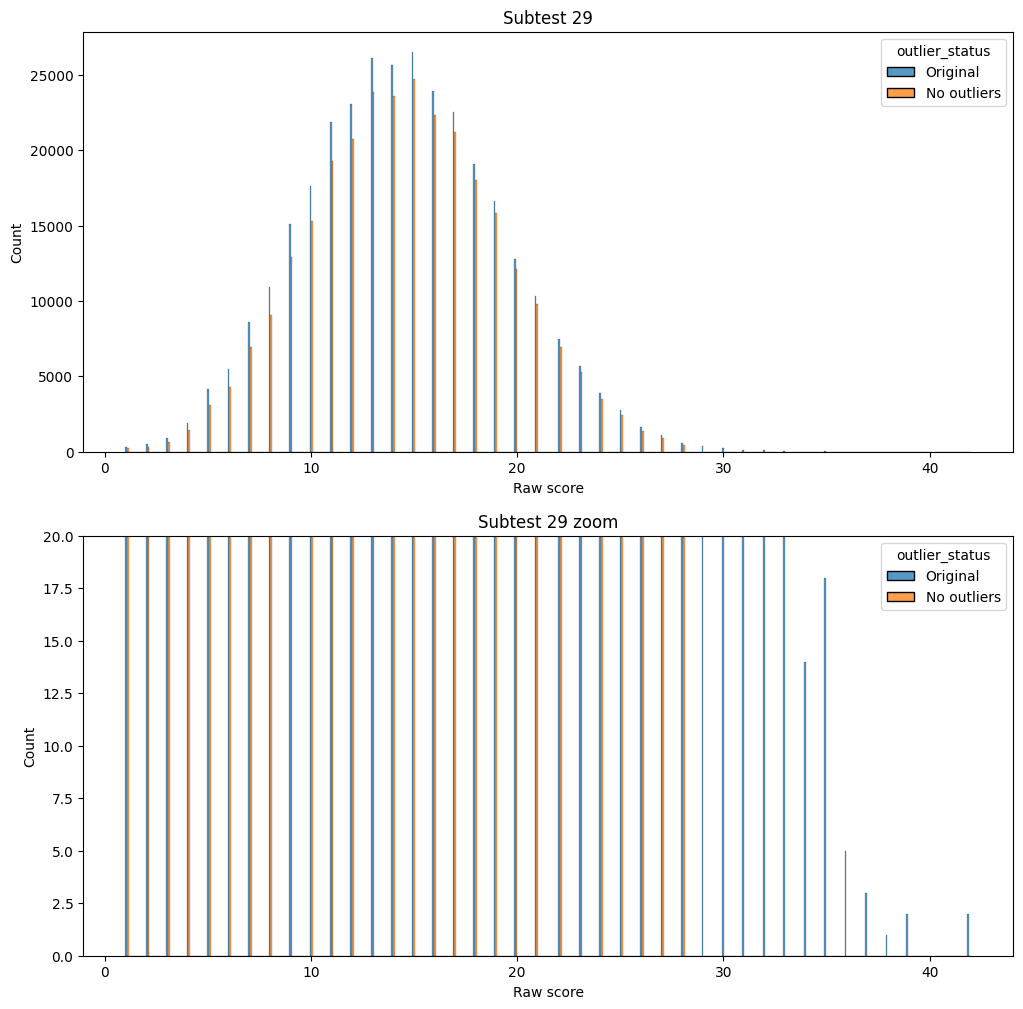

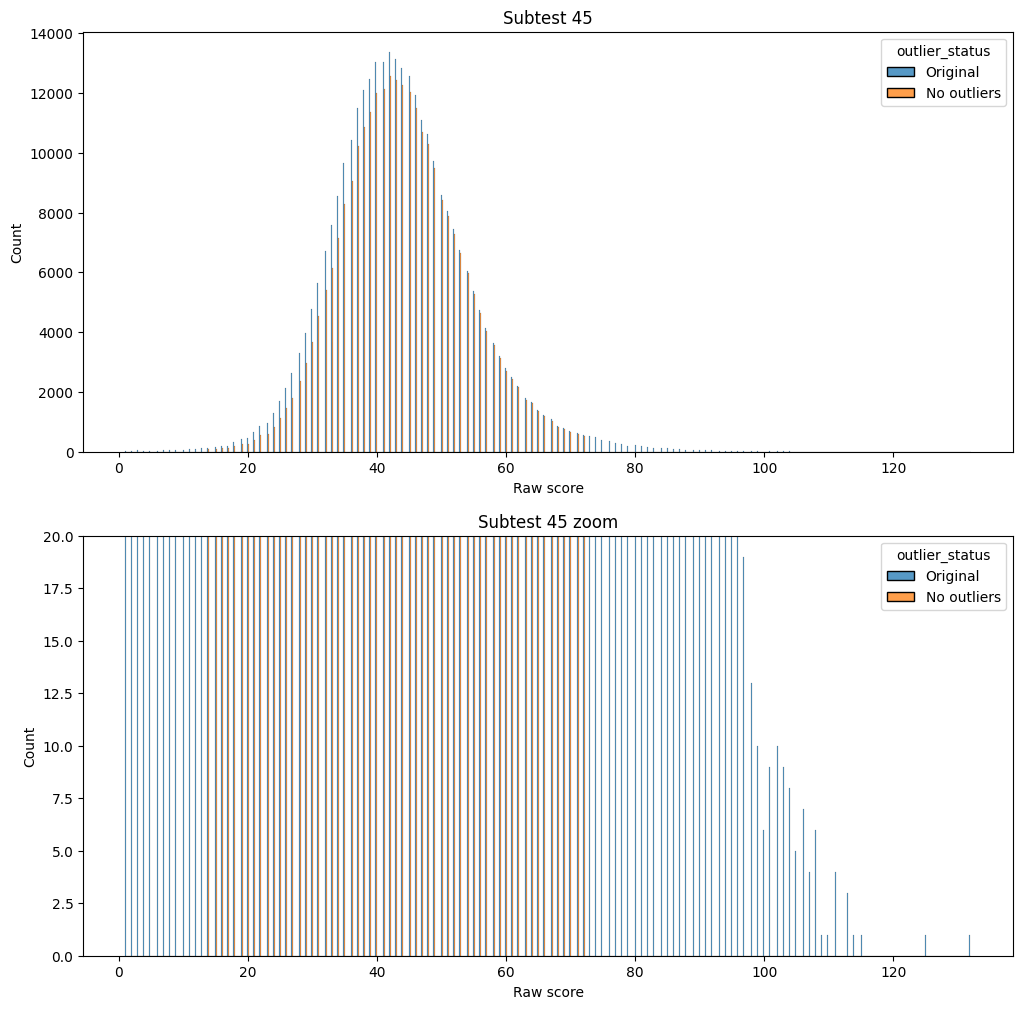

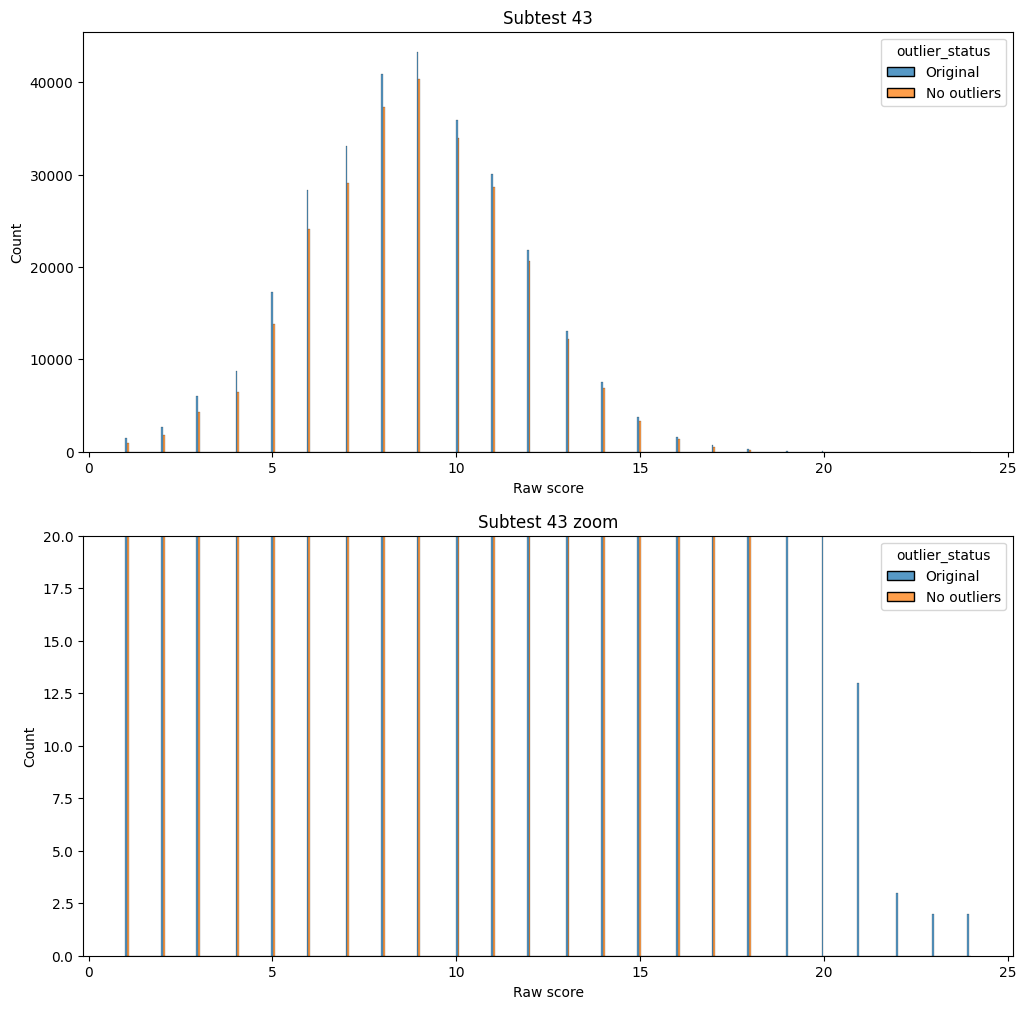

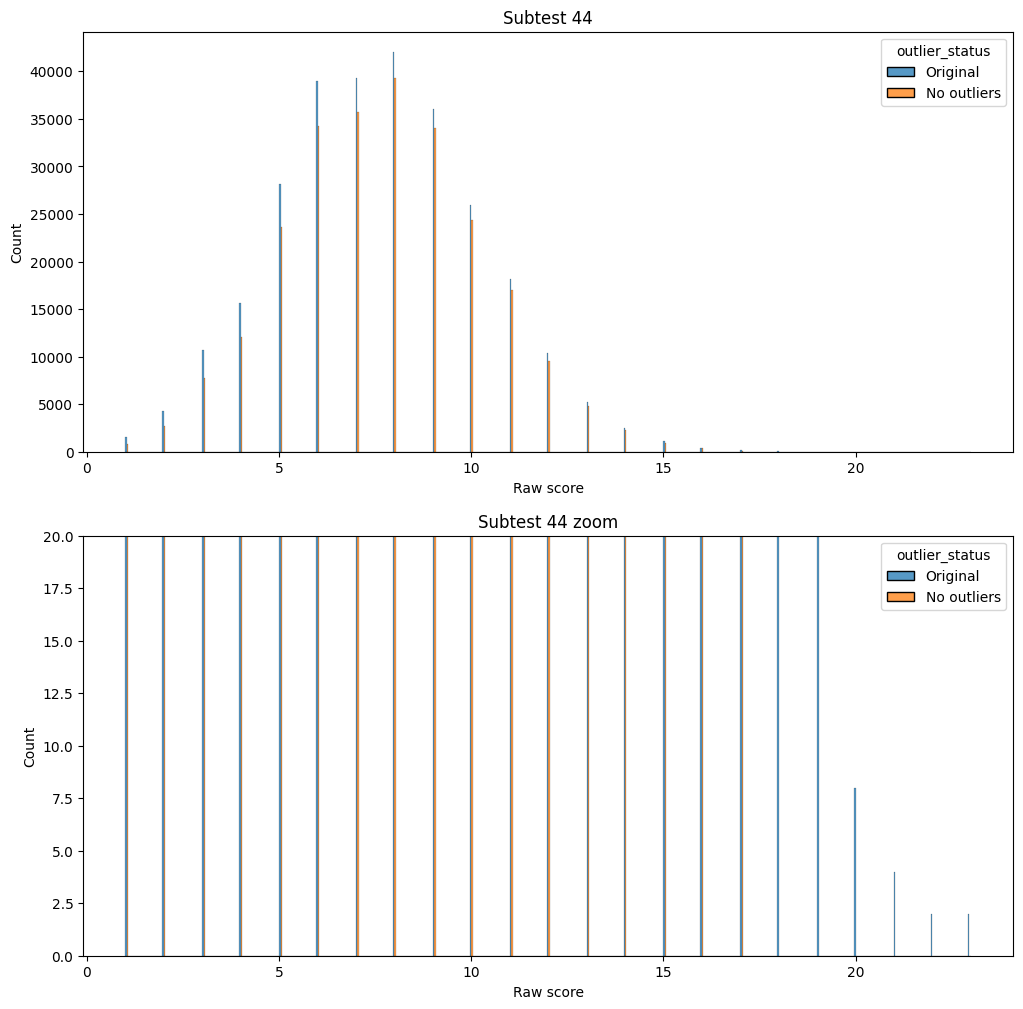

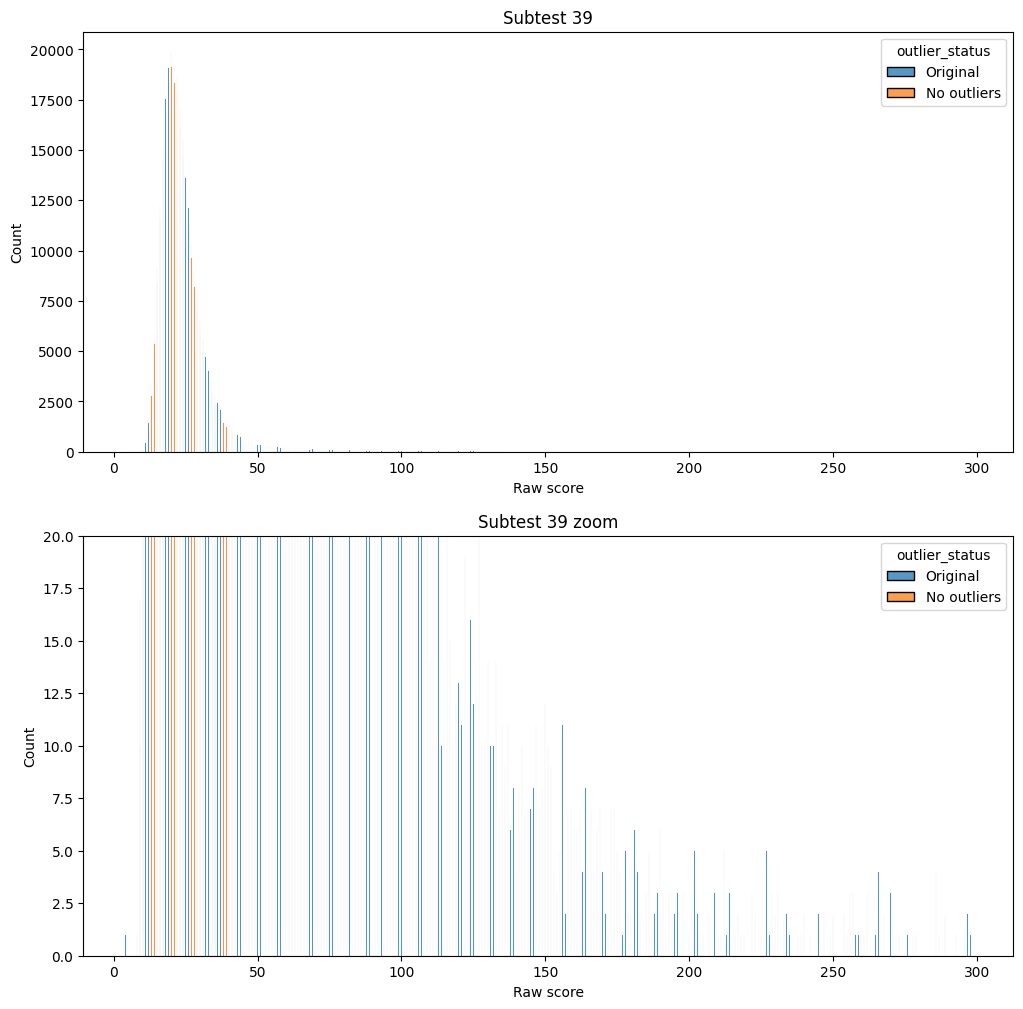

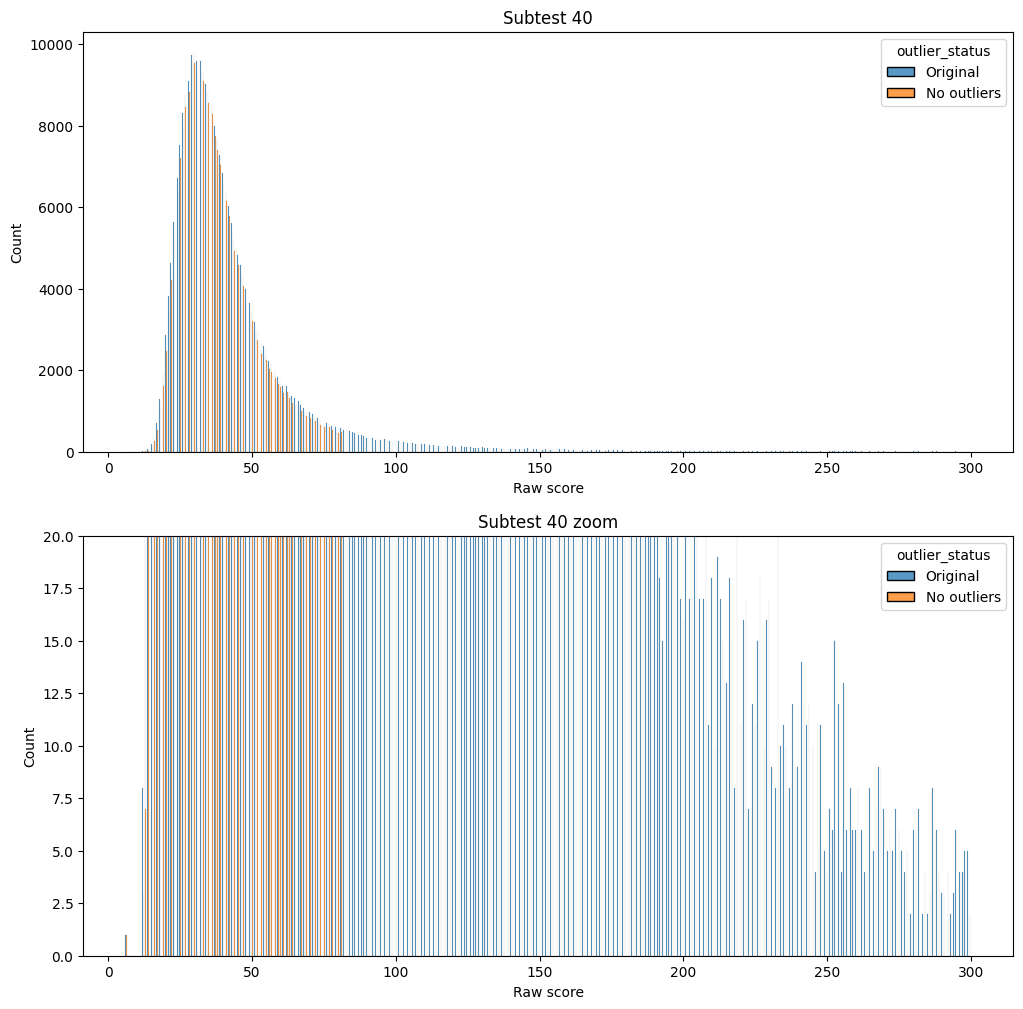

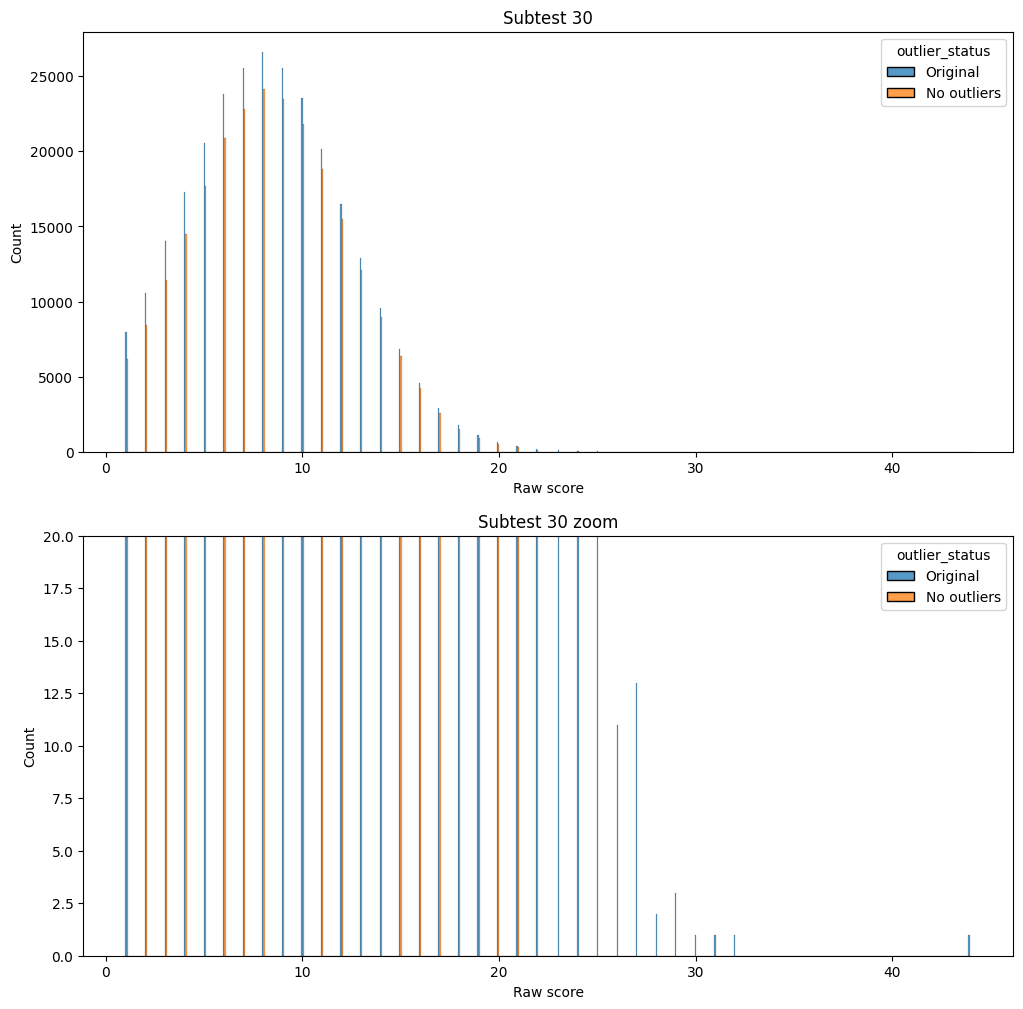

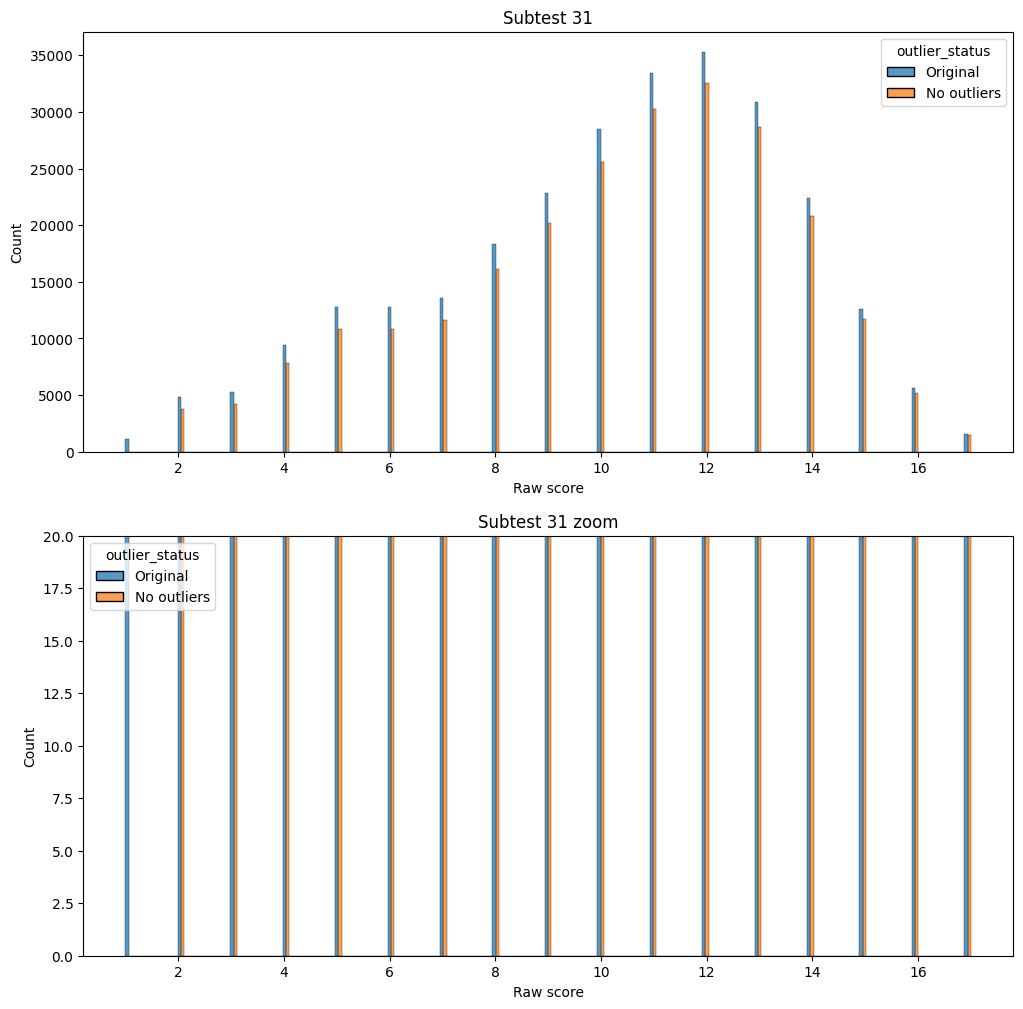

In [ ]:
# Remove outlier raw scores using the median absolute deviation (MAD) method

outlier_threshold = 5 # fairly conservative threshold
outlier_method = 'MAD'
n_bins = 10

outlier_subtests = ncpt.df['specific_subtest_id'].unique().tolist()

zoom_ylim = [0, 20]
filt_df = ncpt.filter_outliers_by_subtest('raw_score', outlier_threshold,
                                          outlier_subtests, method=outlier_method)

# Plot the raw score distributions before and after outlier removal
for sub in outlier_subtests:
    orig_sub_df = ncpt.df.query('specific_subtest_id == @sub')
    orig_sub_df = orig_sub_df.assign(outlier_status='Original')
    filt_sub_df = filt_df.query('specific_subtest_id == @sub')
    filt_sub_df = filt_sub_df.assign(outlier_status='No outliers')
    plot_df = pd.concat([orig_sub_df, filt_sub_df])
    plot_df.reset_index(drop=True, inplace=True)
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    for ax_ind, ax in enumerate(axes):
        sns.histplot(plot_df, x='raw_score', hue='outlier_status', multiple='dodge',
                     ax=ax)
        ax.set_xlabel('Raw score')
        ax.set_ylabel('Count')
        if ax_ind == 1:
            ax.set_ylim(zoom_ylim)
            ax.set_title(f'Subtest {sub} zoom')
        else:
            ax.set_title(f'Subtest {sub}')
    plt.show()

The dataset was in a long format, with each row corresponding to one test completed by one participant. The following code shifts it to a wide format, where each row corresponds to one participant, and their test scores are contained in the columns.

In [ ]:
# Identify Pivoting the dataframe along the "id" axes, AKA axes that are the same throughout multiple rows and need to be condensed
id_cols = ['user_id', 'age', 'gender', 'education_level', 'country', 'test_run_id', 'time_of_day', 'grand_index']
df_reshaped = filt_df.pivot_table(index=id_cols, columns='specific_subtest_id', values='raw_score', aggfunc='mean')
df_reshaped = df_reshaped.reset_index()
subtest_ids = [col for col in df_reshaped.columns if isinstance(col, (int, float))]

new_column_names = {sub_id: f'subtest_{int(sub_id)}_score' for sub_id in subtest_ids}
df_reshaped = df_reshaped.rename(columns=new_column_names)

display(df_reshaped)

specific_subtest_id,user_id,age,gender,education_level,country,test_run_id,time_of_day,grand_index,subtest_29_score,subtest_30_score,subtest_31_score,subtest_39_score,subtest_40_score,subtest_43_score,subtest_44_score,subtest_45_score
0,186,30.0,f,6.0,US,324592,12,117.608789,14.0,9.0,14.0,19.0,29.0,12.0,8.0,61.0
1,773,67.0,f,6.0,US,683448,15,90.813288,17.0,8.0,12.0,26.0,41.0,1.0,3.0,39.0
2,775,49.0,f,4.0,US,715753,11,123.679876,21.0,15.0,13.0,22.0,31.0,11.0,10.0,65.0
3,1209,46.0,f,5.0,US,414935,14,106.854928,17.0,8.0,13.0,24.0,30.0,8.0,7.0,43.0
4,1228,29.0,m,4.0,US,204434,16,136.319361,20.0,14.0,15.0,15.0,23.0,15.0,12.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223655,105417999,25.0,m,6.0,CA,328548,18,120.640855,18.0,14.0,13.0,33.0,28.0,14.0,12.0,51.0
223656,105422276,68.0,f,3.0,US,164783,8,105.502768,17.0,11.0,16.0,20.0,40.0,6.0,6.0,31.0
223657,105435513,79.0,m,3.0,US,262431,8,101.384593,14.0,5.0,13.0,24.0,29.0,8.0,7.0,35.0
223658,105441918,74.0,f,5.0,US,527632,15,95.099140,22.0,8.0,7.0,25.0,28.0,3.0,3.0,37.0


In [ ]:
# Remove rows with any NA values from the reshaped DataFrame
df_reshaped_cleaned = df_reshaped.dropna()
display(df_reshaped_cleaned.head())
print(f"Original: {df_reshaped.shape}")
print(f"Clean: {df_reshaped_cleaned.shape}")

specific_subtest_id,user_id,age,gender,education_level,country,test_run_id,time_of_day,grand_index,subtest_29_score,subtest_30_score,subtest_31_score,subtest_39_score,subtest_40_score,subtest_43_score,subtest_44_score,subtest_45_score
0,186,30.0,f,6.0,US,324592,12,117.608789,14.0,9.0,14.0,19.0,29.0,12.0,8.0,61.0
1,773,67.0,f,6.0,US,683448,15,90.813288,17.0,8.0,12.0,26.0,41.0,1.0,3.0,39.0
2,775,49.0,f,4.0,US,715753,11,123.679876,21.0,15.0,13.0,22.0,31.0,11.0,10.0,65.0
3,1209,46.0,f,5.0,US,414935,14,106.854928,17.0,8.0,13.0,24.0,30.0,8.0,7.0,43.0
4,1228,29.0,m,4.0,US,204434,16,136.319361,20.0,14.0,15.0,15.0,23.0,15.0,12.0,61.0


Original: (223660, 16)
Clean: (223660, 16)


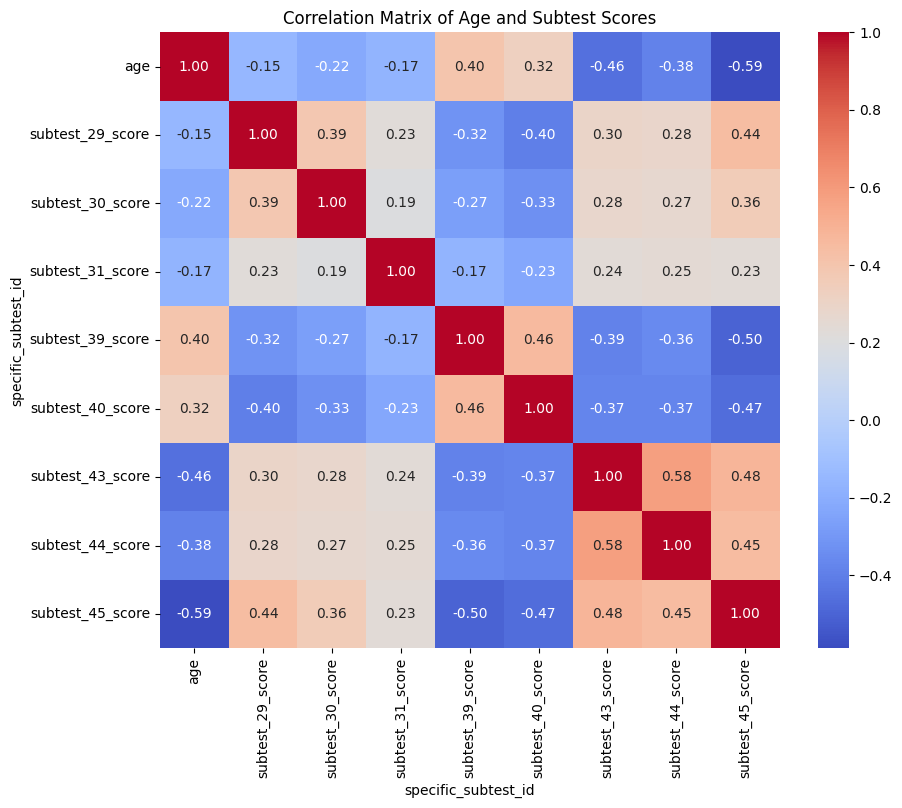

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Uses headers of columns to select the appropriate ones

subtest_cols = [col for col in df_reshaped_cleaned.columns if col.startswith('subtest_')]
correlation_cols = ['age'] + subtest_cols
df_correlation = df_reshaped_cleaned[correlation_cols]
correlation_matrix = df_correlation.corr()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Age and Subtest Scores')
plt.show()

/tmp/ipython-input-2110754236.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='age_decade', y=col, data=df_reshaped_cleaned, palette='viridis')
/tmp/ipython-input-2110754236.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='age_decade', y=col, data=df_reshaped_cleaned, palette='viridis')
/tmp/ipython-input-2110754236.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='age_decade', y=col, data=df_reshaped_cleaned, palette='viridis')
/tmp/ipython-input-2110754236.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is

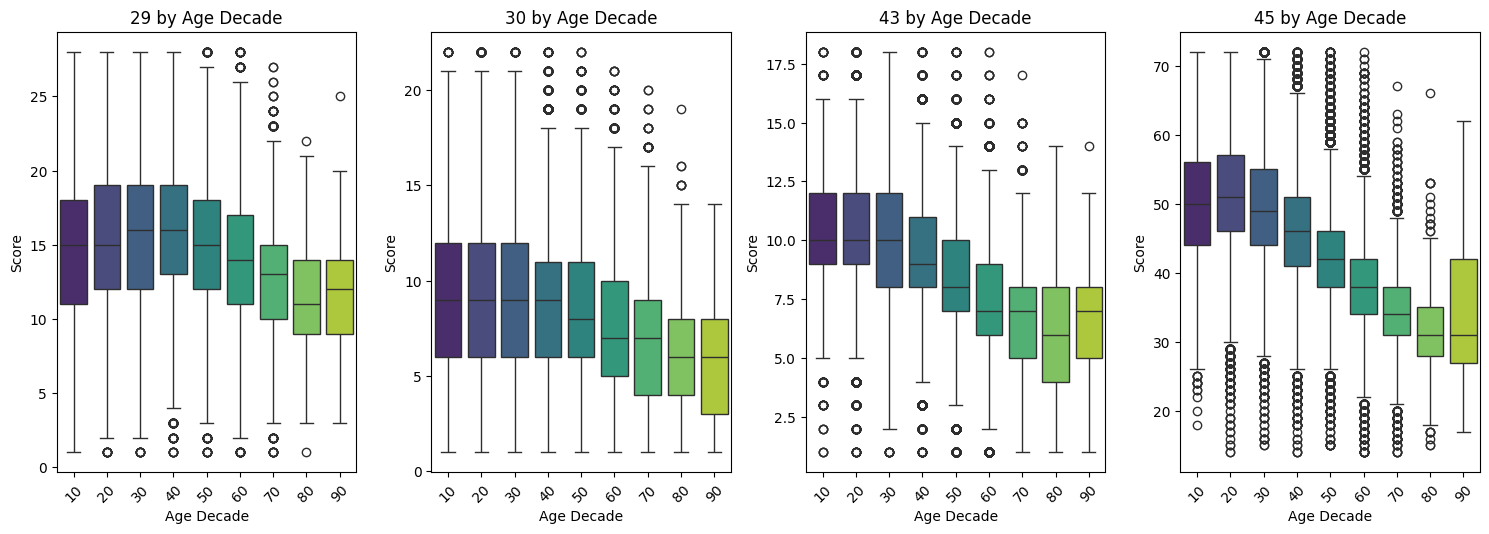

In [ ]:
# Create 'age_decade' column
df_reshaped_cleaned['age_decade'] = (np.floor(df_reshaped_cleaned['age'] / 10) * 10).astype(int)
key_subtest_scores = [f'subtest_{id_str}_score' for id_str in ["29", "30", "43", "45"]]

plt.figure(figsize=(15, 10))
for i, col in enumerate(key_subtest_scores):
    plt.subplot(2, 4, i + 1) # Adjust subplot grid as needed
    sns.boxplot(x='age_decade', y=col, data=df_reshaped_cleaned, palette='viridis')
    plt.title(f'{col.replace("subtest_", "").replace("_score", "")} by Age Decade')
    plt.xlabel('Age Decade')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Preprocessing and EDA for Dallas Dataset


In [ ]:
import pandas as pd
import numpy as np

# 1. Loading excel files
excel_files = [
    '/content/Construct7_VerbalFluency.xlsx',
    '/content/Construct6_Vocabulary.xlsx',
    '/content/Construct2_WorkingMemory.xlsx',
    '/content/Construct5_Reasoning.xlsx',
    '/content/Construct1_SpeedOfProcessing.xlsx'
]
demographic_cols = ['S#', 'AgeInterval', 'Sex', 'Race', 'Ethnicity']
measurement_cols = ['DigCompTotal1', 'DigSymTotal2', 'SptlWMTotErrs4', 'LetNumSeqTot5', 'EtsLsTOTAL21', 'ETSVocab24']

dfs_wave1_processed = []
dfs_wave2_processed = []

for file_path in excel_files:
    xls = pd.ExcelFile(file_path)
    sheet_names = xls.sheet_names

    # Identify Wave 1 and Wave 2 sheet names. I chose not to include Wave 3.

    wave1_sheet_name = next((s for s in sheet_names if 'W1' in s and 'W3' not in s), None)
    wave2_sheet_name = next((s for s in sheet_names if 'W2' in s and 'W3' not in s), None)

    if wave1_sheet_name:
        df_w1 = xls.parse(wave1_sheet_name)
        rename_map_w1 = {col: f'{col}_W1' for col in measurement_cols if col in df_w1.columns}
        if 'WContOralAssocLetterTot29' in df_w1.columns:
            rename_map_w1['WContOralAssocLetterTot29'] = 'WContOralAssocLetterTot29_W1'
        cols_to_select_w1 = demographic_cols + list(rename_map_w1.keys())
        cols_to_select_w1 = [col for col in cols_to_select_w1 if col in df_w1.columns]
        df_w1_processed = df_w1[cols_to_select_w1].rename(columns=rename_map_w1)
        dfs_wave1_processed.append(df_w1_processed)

    if wave2_sheet_name:
        df_w2 = xls.parse(wave2_sheet_name)
        rename_map_w2 = {col: f'{col}_W2' for col in measurement_cols if col in df_w2.columns}
        if 'ContOralAssocTot29' in df_w2.columns:
            rename_map_w2['ContOralAssocTot29'] = 'ContOralAssocTot29_W2'
        cols_to_select_w2 = demographic_cols + list(rename_map_w2.keys())
        cols_to_select_w2 = [col for col in cols_to_select_w2 if col in df_w2.columns]
        df_w2_processed = df_w2[cols_to_select_w2].rename(columns=rename_map_w2)
        dfs_wave2_processed.append(df_w2_processed)

master_df_w1 = dfs_wave1_processed[0]
for i in range(1, len(dfs_wave1_processed)):
    master_df_w1 = pd.merge(master_df_w1, dfs_wave1_processed[i], on=demographic_cols, how='outer')
master_df_w2 = dfs_wave2_processed[0]
for i in range(1, len(dfs_wave2_processed)):
    master_df_w2 = pd.merge(master_df_w2, dfs_wave2_processed[i], on=demographic_cols, how='outer')
df_merged_waves = pd.merge(master_df_w1, master_df_w2, on='S#', how='outer')

# Handle demographic columns

demographic_cols_to_coalesce = [col for col in demographic_cols if col != 'S#']
for col in demographic_cols_to_coalesce:
    col_x = f"{col}_x"
    col_y = f"{col}_y"

    if col_x in df_merged_waves.columns:
        df_merged_waves[col_x] = df_merged_waves[col_x].replace(['xx', 'XX'], np.nan).infer_objects(copy=False)
    if col_y in df_merged_waves.columns:
        df_merged_waves[col_y] = df_merged_waves[col_y].replace(['xx', 'XX'], np.nan).infer_objects(copy=False)

    if col_x in df_merged_waves.columns and col_y in df_merged_waves.columns:
        df_merged_waves[col] = df_merged_waves[col_x].fillna(df_merged_waves[col_y])
        df_merged_waves = df_merged_waves.drop(columns=[col_x, col_y])
    elif col_x in df_merged_waves.columns:
        df_merged_waves[col] = df_merged_waves[col_x]
        df_merged_waves = df_merged_waves.drop(columns=[col_x])
    elif col_y in df_merged_waves.columns:
        df_merged_waves[col] = df_merged_waves[col_y]

all_measurement_cols = [
    *[f'{col}_W1' for col in measurement_cols],
    'WContOralAssocLetterTot29_W1',
    *[f'{col}_W2' for col in measurement_cols],
    'ContOralAssocTot29_W2'
]
for col in all_measurement_cols:
    if col in df_merged_waves.columns:
        df_merged_waves[col] = df_merged_waves[col].replace(['xx', 'XX'], np.nan)
        df_merged_waves[col] = pd.to_numeric(df_merged_waves[col], errors='coerce')


all_measurement_cols_w1 = [f'{col}_W1' for col in measurement_cols] + ['WContOralAssocLetterTot29_W1']
all_measurement_cols_w2 = [f'{col}_W2' for col in measurement_cols] + ['ContOralAssocTot29_W2']
final_columns_order = demographic_cols + all_measurement_cols_w1 + all_measurement_cols_w2
existing_final_columns = [col for col in final_columns_order if col in df_merged_waves.columns]
df_merged_waves = df_merged_waves[existing_final_columns]

# Removes columns with ANY missing values

columns_to_check_for_na = [
    'DigCompTotal1_W1', 'DigSymTotal2_W1', 'SptlWMTotErrs4_W1', 'LetNumSeqTot5_W1', 'ETSVocab24_W1', 'WContOralAssocLetterTot29_W1',
    'DigCompTotal1_W2', 'DigSymTotal2_W2', 'SptlWMTotErrs4_W2', 'LetNumSeqTot5_W2', 'ETSVocab24_W2', 'ContOralAssocTot29_W2'
]
existing_columns_to_check = [col for col in columns_to_check_for_na if col in df_merged_waves.columns]
df_merged_waves = df_merged_waves.dropna(subset=existing_columns_to_check)

print("df_merged_waves created successfully.")
print("Head of the final merged DataFrame:")
display(df_merged_waves)
print(len(df_merged_waves))


df_merged_waves created successfully.
Head of the final merged DataFrame:


/tmp/ipython-input-2723157767.py:70: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged_waves[col_y] = df_merged_waves[col_y].replace(['xx', 'XX'], np.nan).infer_objects(copy=False)
/tmp/ipython-input-2723157767.py:70: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged_waves[col_y] = df_merged_waves[col_y].replace(['xx', 'XX'], np.nan).infer_objects(copy=False)
/tmp/ipython-input-2723157767.py:91: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old beh

,S#,AgeInterval,Sex,Race,Ethnicity,DigCompTotal1_W1,DigSymTotal2_W1,SptlWMTotErrs4_W1,LetNumSeqTot5_W1,ETSVocab24_W1,WContOralAssocLetterTot29_W1,DigCompTotal1_W2,DigSymTotal2_W2,SptlWMTotErrs4_W2,LetNumSeqTot5_W2,ETSVocab24_W2,ContOralAssocTot29_W2
0,12,53-55,f,5,0.0,66.0,57.0,52.0,13.0,27.25,34.0,70.0,54.0,15.0,13.0,26.75,30.0
2,49,68-70,f,5,0.0,55.0,46.0,31.0,8.0,22.75,35.0,47.0,46.0,32.0,4.0,21.00,31.0
3,61,53-55,f,2,0.0,65.0,71.0,38.0,9.0,12.00,32.0,70.0,69.0,22.0,10.0,17.25,32.0
4,80,38-40,m,5,0.0,77.0,51.0,13.0,9.0,12.75,27.0,71.0,48.0,11.0,10.0,8.25,26.0
5,81,38-40,f,5,0.0,77.0,78.0,8.0,14.0,25.25,56.0,80.0,79.0,0.0,13.0,25.00,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,4841,65-67,f,5,0.0,59.0,54.0,42.0,13.0,23.50,39.0,53.0,55.0,71.0,10.0,23.50,55.0
460,4847,68-70,f,5,0.0,62.0,35.0,58.0,8.0,24.75,46.0,51.0,33.0,70.0,7.0,20.00,41.0
461,4868,62-64,f,5,0.0,43.0,58.0,47.0,9.0,17.50,29.0,56.0,60.0,42.0,9.0,18.50,24.0
462,4869,71-73,m,5,0.0,56.0,34.0,26.0,8.0,13.00,24.0,40.0,27.0,39.0,9.0,13.00,35.0


312


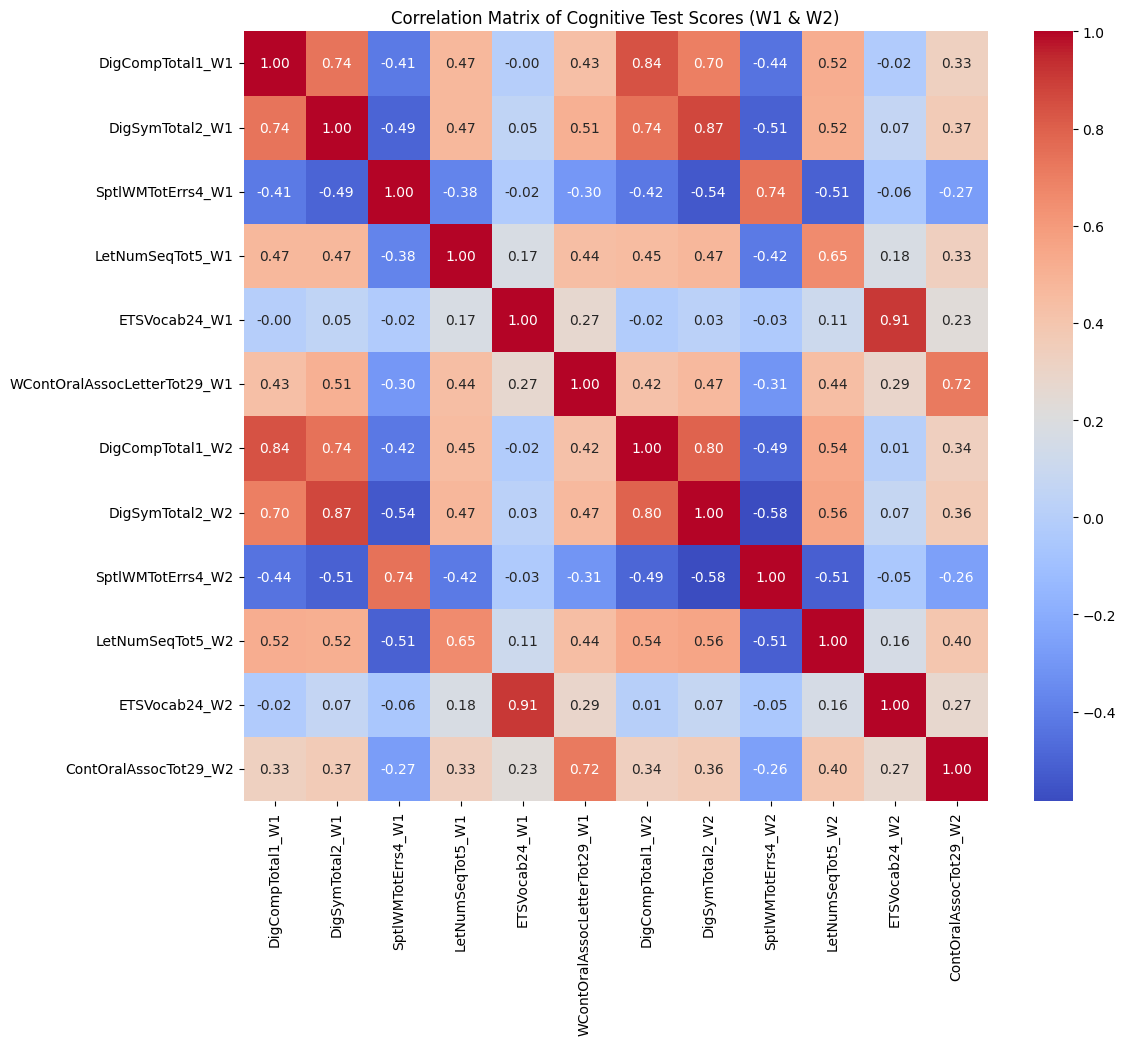

In [ ]:
test_score_columns = [col for col in all_measurement_cols if col in df_merged_waves.columns]
df_test_scores = df_merged_waves[test_score_columns]
correlation_matrix_tests = df_test_scores.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_tests, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Cognitive Test Scores (W1 & W2)')
plt.show()

In [ ]:
wave_map = {
    'DigCompTotal1_W1': 'DigCompTotal1_W2',
    'DigSymTotal2_W1': 'DigSymTotal2_W2',
    'SptlWMTotErrs4_W1': 'SptlWMTotErrs4_W2',
    'LetNumSeqTot5_W1': 'LetNumSeqTot5_W2',
    'ETSVocab24_W1': 'ETSVocab24_W2',
    'WContOralAssocLetterTot29_W1': 'ContOralAssocTot29_W2'
}

avg_scores_list = []

for w1_col, w2_col in wave_map.items():
    test_name = w1_col.replace('_W1', '')
    avg_w1 = df_merged_waves[w1_col].mean()
    avg_w2 = df_merged_waves[w2_col].mean()

    avg_scores_list.append({
        'Test_Name': test_name,
        'Wave1_Average': avg_w1,
        'Wave2_Average': avg_w2
    })

df_averages = pd.DataFrame(avg_scores_list)

display(df_averages.head())

,Test_Name,Wave1_Average,Wave2_Average
0,DigCompTotal1,62.227564,58.666667
1,DigSymTotal2,54.907051,50.945513
2,SptlWMTotErrs4,31.573718,30.381410
3,LetNumSeqTot5,11.000000,10.974359
4,ETSVocab24,19.483974,19.375801


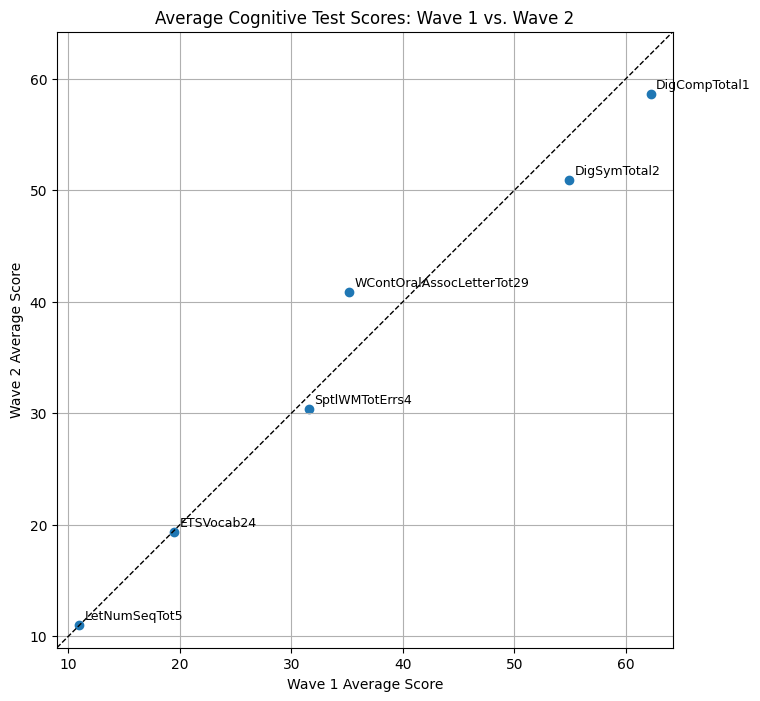

In [ ]:
# Scatter of Wave 1 scores vs. Wave 2 scores, expecting points to be below the line to show performance largely worsens with age

plt.figure(figsize=(10, 8))


plt.scatter(df_averages['Wave1_Average'], df_averages['Wave2_Average'])
min_val = min(df_averages['Wave1_Average'].min(), df_averages['Wave2_Average'].min()) - 2
max_val = max(df_averages['Wave1_Average'].max(), df_averages['Wave2_Average'].max()) + 2

for i, row in df_averages.iterrows():
    plt.text(row['Wave1_Average'] + 0.5, row['Wave2_Average'] + 0.5, row['Test_Name'], fontsize=9)

plt.xlabel('Wave 1 Average Score')
plt.ylabel('Wave 2 Average Score')
plt.title('Average Cognitive Test Scores: Wave 1 vs. Wave 2')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

#Diagonal line = equal performance
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.show()

# Regression Neural Net for NCPT *


Data preprocessing (X_processed and y) completed.
Custom piecewise Huber loss function redefined.

Train/test split completed. X_train shape: (178928, 15), X_test shape: (44732, 15)

Neural network model architecture defined.
Model compiled with custom piecewise Huber loss and Adam optimizer (lr=0.0002).
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 32.6585 - mean_absolute_error: 38.7935 - val_loss: 13.2903 - val_mean_absolute_error: 16.0646
Epoch 2/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 10.7491 - mean_absolute_error: 13.0955 - val_loss: 8.3859 - val_mean_absolute_error: 10.3155
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 8.2827 - mean_absolute_error: 10.2031 - val_loss: 8.1041 - val_mean_absolute_error: 9.9851
Epoch 4/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.0373 - mean_absolute_error: 9.9178 - val_loss: 7.8934 - val_mean_absolute_error: 9.7374
Epoch 5/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.8144 - mean_absolute_error: 9.6489 - val_loss: 7.7092 - val_mean_absolute_error: 9.5210
Epoch 6/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 7.6049 - mean_absolute_error: 9.4017 - val_loss: 7.5237 - val_mean_absolute_error: 9.3031
Epoch 7/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 7.5102 - mean_absolute_error: 9.2917 - val

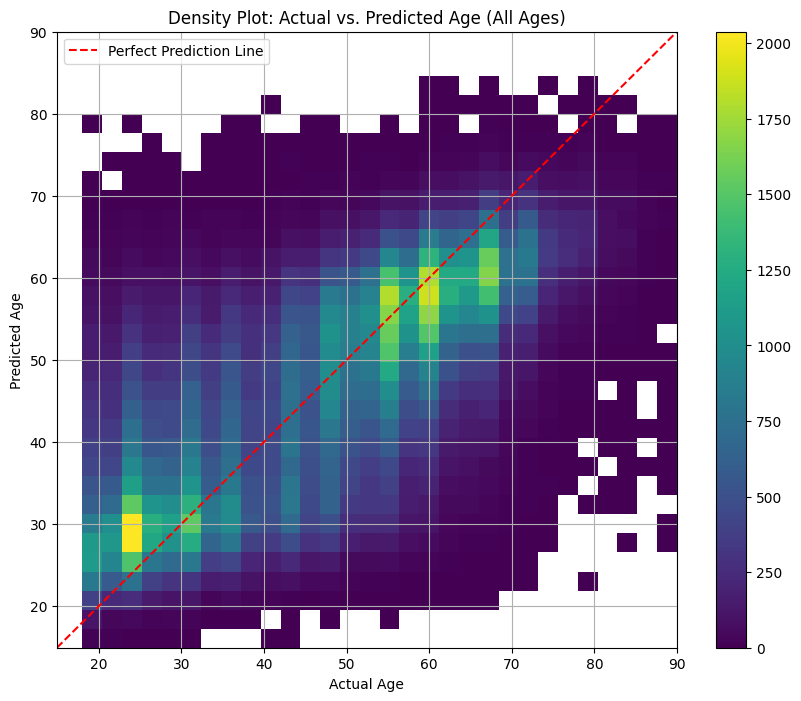

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

# Target and input processing

y = df_reshaped_cleaned['age']

columns_to_drop = ['age', 'user_id', 'test_run_id', 'age_decade']
if 'predicted_age' in df_reshaped_cleaned.columns:
    columns_to_drop.append('predicted_age')
X = df_reshaped_cleaned.drop(columns=columns_to_drop)

categorical_cols = ['gender', 'education_level', 'country']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# One-hot encoding for the categorical features in X

X_categorical = pd.get_dummies(X[categorical_cols], drop_first=True)
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X[numerical_cols])
X_numerical_scaled = pd.DataFrame(X_numerical_scaled, columns=numerical_cols, index=X.index)
X_processed = pd.concat([X_categorical, X_numerical_scaled], axis=1)

# Custon loss function using Huber loss from keras

@tf.keras.utils.register_keras_serializable()
def piecewise_huber_loss(y_true, y_pred):
    huber_fn = Huber(reduction=tf.keras.losses.Reduction.NONE)
    huber_loss = huber_fn(y_true, y_pred)
    condition = tf.logical_or(tf.less(y_true, 30.0), tf.greater(y_true, 70.0))
    weighted_huber_loss = tf.where(condition, huber_loss * 1.0, huber_loss * 0.8)
    return tf.reduce_mean(weighted_huber_loss)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y,
                                                    test_size=0.2, random_state=26)

input_dim = X_train.shape[1]
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(input_dim,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

adam_optimizer = Adam(learning_rate=0.0002)
model.compile(optimizer=adam_optimizer, loss=piecewise_huber_loss, metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, epochs=10, batch_size=500, validation_data=(X_test, y_test), verbose=1)
final_val_mae = history.history['val_mean_absolute_error'][-1]
print(f"Final Validation Mean Absolute Error: {final_val_mae:.4f}")



In [ ]:
y_pred_full = model.predict(X_processed).flatten()
df_reshaped_cleaned['predicted_age'] = y_pred_full

# Density plot, since scatter was pretty unfavorable

plt.figure(figsize=(10, 8))
sns.histplot(x='age', y='predicted_age', data=df_reshaped_cleaned, cmap='viridis', cbar=True, bins=30)

# Diagnoal line = perfect job (identity line)

min_val = min(df_reshaped_cleaned['age'].min(), df_reshaped_cleaned['predicted_age'].min())
max_val = max(df_reshaped_cleaned['age'].max(), df_reshaped_cleaned['predicted_age'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction Line')

plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Density Plot: Actual vs. Predicted Age (All Ages)')
plt.legend()
plt.grid(True)
plt.show()

# Feature Analysis on Regression Neural Net


--- Performing Permutation Importance Analysis ---
Baseline Accuracy on Test Set: 9.0637
Shuffling feature: education_level
Shuffling feature: gender_m
Shuffling feature: country_CA
Shuffling feature: country_NZ
Shuffling feature: country_US
Shuffling feature: time_of_day
Shuffling feature: grand_index
Shuffling feature: subtest_29_score
Shuffling feature: subtest_30_score
Shuffling feature: subtest_31_score
Shuffling feature: subtest_39_score
Shuffling feature: subtest_40_score
Shuffling feature: subtest_43_score
Shuffling feature: subtest_44_score
Shuffling feature: subtest_45_score

Permutation Importance Results (sorted):
country_NZ         -0.001163
country_CA         -0.019767
subtest_44_score   -0.034148
subtest_40_score   -0.064850
subtest_31_score   -0.082228
country_US         -0.084490
subtest_30_score   -0.106273
time_of_day        -0.116468
subtest_39_score   -0.117168
subtest_43_score   -0.155550
education_level    -0.302001
gender_m           -0.357958
subtest_29_score 

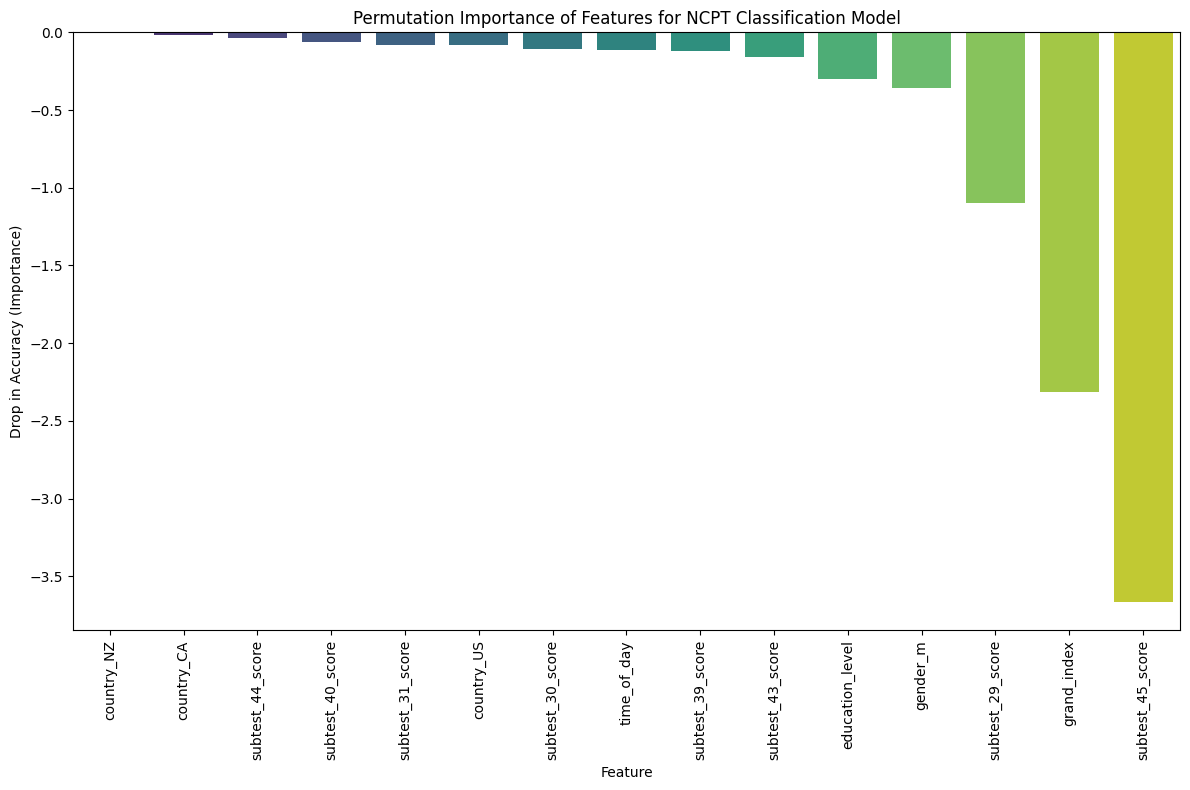

Permutation importance analysis completed and visualized.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

loss_baseline, baseline_accuracy = model.evaluate(X_test, y_test, verbose=0)
feature_names = X_test.columns.tolist()
permutation_importances = {}

X_test_shuffled = X_test.copy()
for feature in feature_names:
    print(f"Shuffling feature: {feature}")
    original_feature_values = X_test_shuffled[feature].copy()
    shuffled_values = np.random.permutation(original_feature_values)
    X_test_shuffled[feature] = shuffled_values
    loss_shuffled, shuffled_accuracy = model.evaluate(X_test_shuffled, y_test, verbose=0)

    importance = baseline_accuracy - shuffled_accuracy
    permutation_importances[feature] = importance
    X_test_shuffled[feature] = original_feature_values

permutation_importances_series = pd.Series(permutation_importances)
permutation_importances_series = permutation_importances_series.sort_values(ascending=False)

print("\nPermutation Importance Results (sorted):")
print(permutation_importances_series)

plt.figure(figsize=(12, 8))
sns.barplot(x=permutation_importances_series.index, y=permutation_importances_series.values, hue=permutation_importances_series.index, palette='viridis', legend=False)
plt.title('Permutation Importance of Features for NCPT Classification Model')
plt.xlabel('Feature')
plt.ylabel('Drop in Accuracy (Importance)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("Permutation importance analysis completed and visualized.")

# Classification Neural Net for NCPT (Not Used)


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Uses one hot encoding to make 16 bins for predictions/classification

age_data_for_bins = df_reshaped_cleaned['age']
y_binned = pd.qcut(age_data_for_bins, q=16, labels=False, duplicates='drop')
y_binned_reshaped = y_binned.values.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_binned_ohe = encoder.fit_transform(y_binned_reshaped)

print(f"Shape of y_binned_ohe: {y_binned_ohe.shape}")

Age binning and one-hot encoding completed for classification model.
Shape of y_binned_ohe: (223660, 16)


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_binned_ohe,
                                                    test_size=0.2, random_state=42)



input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(input_dim,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))

adam_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


Train/test split completed. X_train shape: (178928, 15), X_test shape: (44732, 15)
y_train shape: (178928, 16), y_test shape: (44732, 16)

Neural network model architecture defined.
Model compiled with categorical crossentropy loss and Adam optimizer.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

history = model.fit(X_train, y_train, epochs=20, batch_size=500, validation_data=(X_test, y_test), verbose=1)
final_val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")


Starting model training...
Epoch 1/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.1379 - loss: 2.5528 - val_accuracy: 0.1664 - val_loss: 2.4231
Epoch 2/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1687 - loss: 2.4166 - val_accuracy: 0.1737 - val_loss: 2.4094
Epoch 3/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1721 - loss: 2.4062 - val_accuracy: 0.1733 - val_loss: 2.4044
Epoch 4/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.1744 - loss: 2.4031 - val_accuracy: 0.1740 - val_loss: 2.4020
Epoch 5/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.1749 - loss: 2.3954 - val_accuracy: 0.1744 - val_loss: 2.4003
Epoch 6/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1772 - loss: 2.3918 - val_accuracy: 0.1749 - val_loss: 2.4006
Epoch 7/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.1749 - loss: 2.3943 - val_accuracy: 0.1731 - val_loss: 2.3984
Epoch 8/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.1776

In [ ]:
import numpy as np
import pandas as pd

age_data_for_bins = df_reshaped_cleaned['age']
y_binned_actual = pd.qcut(age_data_for_bins, q=16, labels=False, duplicates='drop')

merged_bins_df = pd.DataFrame({
    'age': age_data_for_bins,
    'age_bin': y_binned_actual
}).reset_index(drop=True)

# 2. Calculate the mean age for each unique bin
mean_age_per_bin = merged_bins_df.groupby('age_bin')['age'].mean()

print("Mean age for each age bin calculated:")
print(mean_age_per_bin)

Mean age for each age bin calculated:
age_bin
0     20.295732
1     24.017981
2     26.973935
3     29.976088
4     33.455585
5     37.970880
6     42.553271
7     46.516121
8     50.037893
9     53.014424
10    55.491994
11    57.989012
12    60.983149
13    63.974730
14    67.326167
15    73.999848
Name: age, dtype: float64


In [ ]:
import numpy as np

# Use the trained classification model to predict age bin probabilities for X_processed.
# The output will be a 2D array where each row represents a sample and each column represents the probability of belonging to that age bin.
predicted_probabilities = model.predict(X_processed)
predicted_age_bins = np.argmax(predicted_probabilities, axis=1)

predicted_ages_from_bins = np.array([mean_age_per_bin[bin_idx] for bin_idx in predicted_age_bins])
df_reshaped_cleaned['predicted_age_binned'] = predicted_ages_from_bins

display(df_reshaped_cleaned[['age', 'predicted_age_binned']])

6990/6990 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
Predicted age bins mapped to mean ages and added to df_reshaped_cleaned_no_outliers.
Head of df_reshaped_cleaned_no_outliers with new 'predicted_age_binned' column:


specific_subtest_id,age,predicted_age_binned
0,30.0,33.455585
1,67.0,67.326167
2,49.0,33.455585
3,46.0,57.989012
4,29.0,26.973935
...,...,...
223655,25.0,33.455585
223656,68.0,67.326167
223657,79.0,60.983149
223658,74.0,67.326167


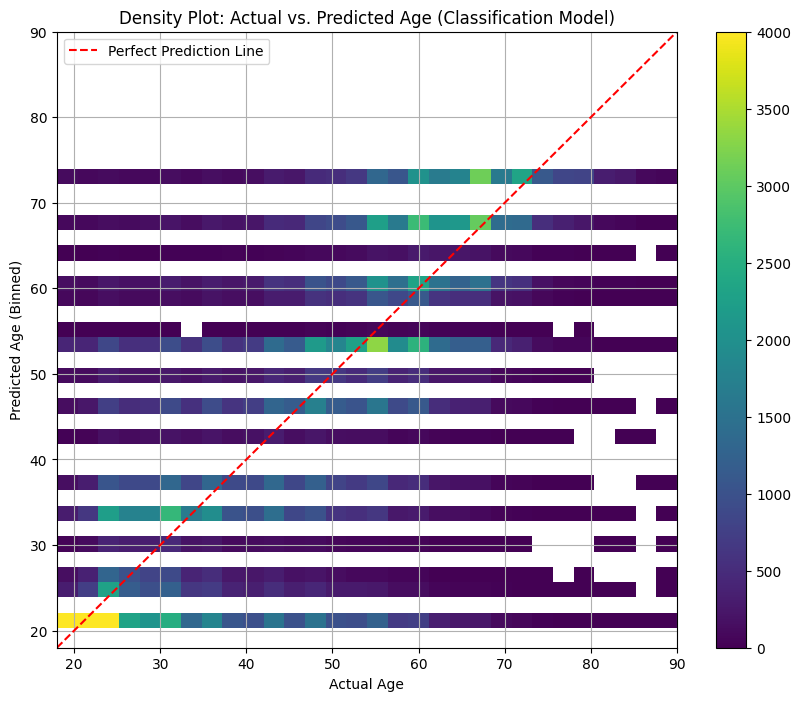

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a density plot of actual vs. predicted age from the classification model
plt.figure(figsize=(10, 8))
sns.histplot(x='age', y='predicted_age_binned', data=df_reshaped_cleaned, cmap='viridis', cbar=True, bins=30, vmax=4000)

min_val_cls = min(df_reshaped_cleaned['age'].min(), df_reshaped_cleaned['predicted_age_binned'].min())
max_val_cls = max(df_reshaped_cleaned['age'].max(), df_reshaped_cleaned['predicted_age_binned'].max())
plt.plot([min_val_cls, max_val_cls], [min_val_cls, max_val_cls], 'r--', label='Perfect Prediction Line')

plt.xlim(min_val_cls, max_val_cls)
plt.ylim(min_val_cls, max_val_cls)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age (Binned)')
plt.title('Density Plot: Actual vs. Predicted Age (Classification Model)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd

predicted_age_bins_series = pd.Series(predicted_age_bins, index=y_binned_actual.index)

# Calculate within 1, then 2 bins accuracy
correct_predictions_within_1_bin = 0
correct_predictions_within_2_bins = 0
total_predictions = len(y_binned_actual)

for actual_bin, predicted_bin in zip(y_binned_actual, predicted_age_bins_series):
    if (predicted_bin == actual_bin or
        predicted_bin == actual_bin - 1 or
        predicted_bin == actual_bin + 1):
        correct_predictions_within_1_bin += 1

    if (predicted_bin == actual_bin or
        predicted_bin == actual_bin - 1 or
        predicted_bin == actual_bin + 1 or
        predicted_bin == actual_bin - 2 or
        predicted_bin == actual_bin + 2):
        correct_predictions_within_2_bins += 1

within_1_bin_accuracy = correct_predictions_within_1_bin / total_predictions
within_2_bin_accuracy = correct_predictions_within_2_bins / total_predictions

print(f"'Within 1 Bin' Accuracy: {within_1_bin_accuracy:.4f}")
print(f"'Within 2 Bins' Accuracy: {within_2_bin_accuracy:.4f}")

'Within 1 Bin' Accuracy: 0.3934
'Within 2 Bins' Accuracy: 0.5514


# Random Forest for Dallas Dataset


Shape of X_aligned after processing: (312, 6)
Shape of y_aligned after processing: (312,)
X_train shape: (249, 6)
X_test shape: (63, 6)
y_train shape: (249,)
y_test shape: (63,)
Random Forest Regressor model trained successfully.

Mean Absolute Error (MAE): 9.88
Mean Squared Error (MSE): 170.74
R-squared (R2) Score: 0.46


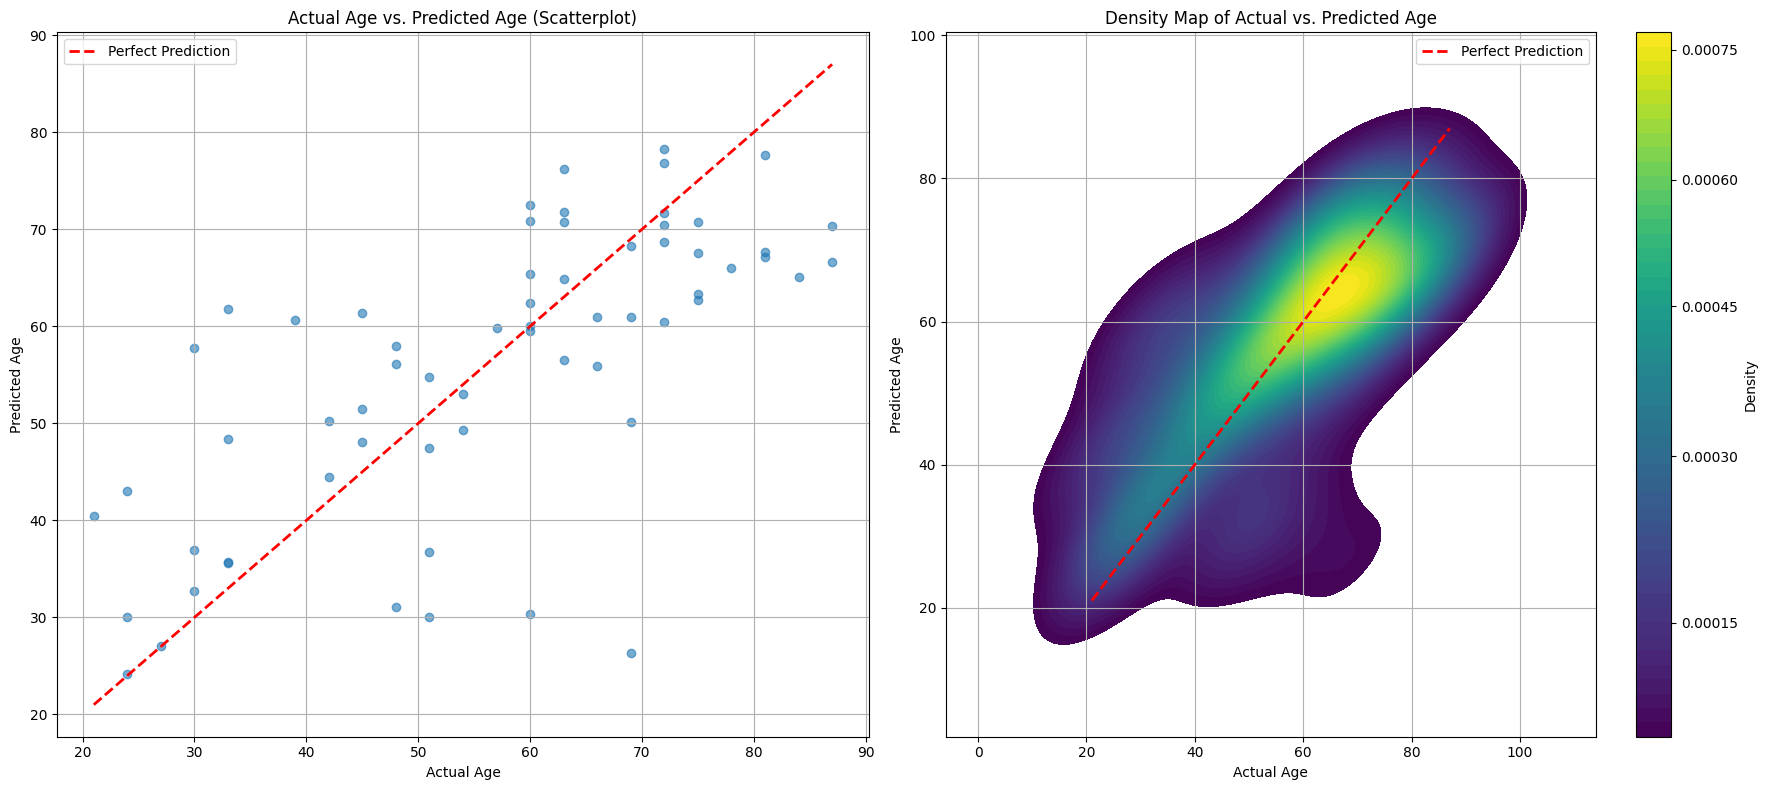

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Calculate the midpoint of each age interval for analysis/prediction error
def calculate_midpoint(age_interval):
    if pd.isna(age_interval):
        return np.nan
    s_age = str(age_interval)
    if s_age.lower() == 'xx':
        return np.nan
    if '-' in s_age:
        try:
            start, end = map(float, s_age.split('-'))
            return (start + end) / 2
        except ValueError:
            return np.nan
    else:
        try:
            return float(s_age)
        except ValueError:
            return np.nan

y_continuous = df_merged_waves['AgeInterval'].apply(calculate_midpoint)

feature_cols_w1 = [col for col in df_merged_waves.columns if col.endswith('_W1')]
X_features = df_merged_waves[feature_cols_w1].copy()
X_features = X_features.apply(pd.to_numeric, errors='coerce')
aligned_indices = X_features.dropna().index.intersection(y_continuous.dropna().index)
X_aligned = X_features.loc[aligned_indices]
y_aligned = y_continuous.loc[aligned_indices]

print(f"Shape of X_aligned after processing: {X_aligned.shape}")
print(f"Shape of y_aligned after processing: {y_aligned.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_aligned, y_aligned, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
random_forest_regressor_model = RandomForestRegressor(random_state=42)
random_forest_regressor_model.fit(X_train, y_train)
print("Random Forest Regressor model trained successfully.")
y_pred_regressor = random_forest_regressor_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_regressor)
mse = mean_squared_error(y_test, y_pred_regressor)
r2 = r2_score(y_test, y_pred_regressor)
print(f"\nMean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator


fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Scatter plot

axes[0].scatter(y_test, y_pred_regressor, alpha=0.6)
axes[0].plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--',
    lw=2,
    label='Perfect Prediction'
)

axes[0].set_title('Actual Age vs. Predicted Age (Scatterplot)')
axes[0].set_xlabel('Actual Age')
axes[0].set_ylabel('Predicted Age')
axes[0].legend()
axes[0].grid(True)

# Density plot
sns.kdeplot(
    x=y_test,
    y=y_pred_regressor,
    cmap='viridis',
    fill=True,
    levels=50,
    ax=axes[1]
)

axes[1].plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--',
    lw=2,
    label='Perfect Prediction'
)

axes[1].set_title('Density Map of Actual vs. Predicted Age')
axes[1].set_xlabel('Actual Age')
axes[1].set_ylabel('Predicted Age')
axes[1].legend()
axes[1].grid(True)

mappable = axes[1].collections[0]
cbar = fig.colorbar(mappable, ax=axes[1])

cbar.locator = MaxNLocator(nbins=6)
cbar.set_label('Density')


plt.tight_layout()
plt.show()





# Feature Analysis on Random Forest

WARNING: THIS PART ALWAYS TAKES ME FOREVER TO RUN

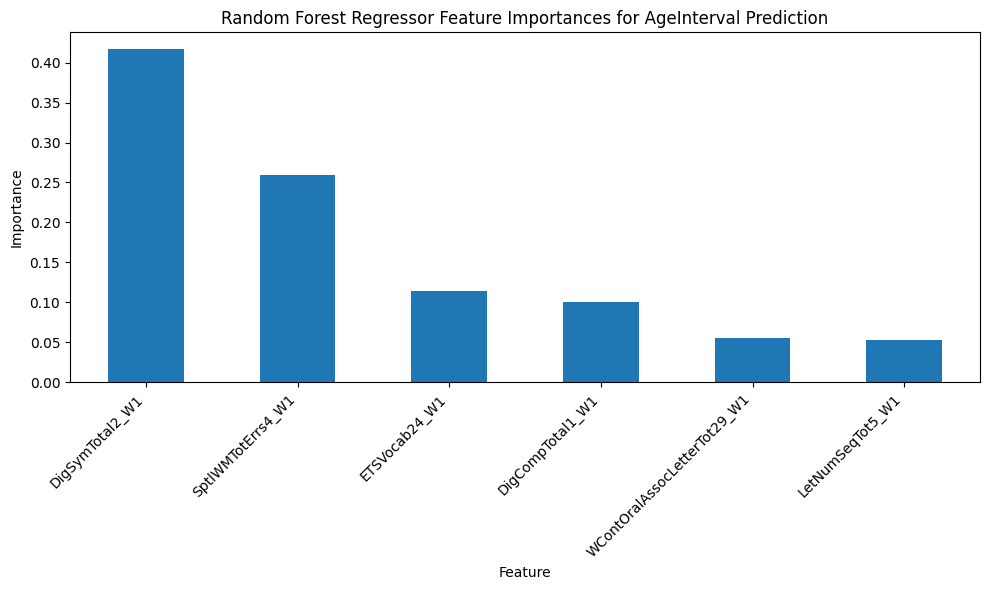


Top 2 most important features for Regressor: ['DigSymTotal2_W1', 'SptlWMTotErrs4_W1']


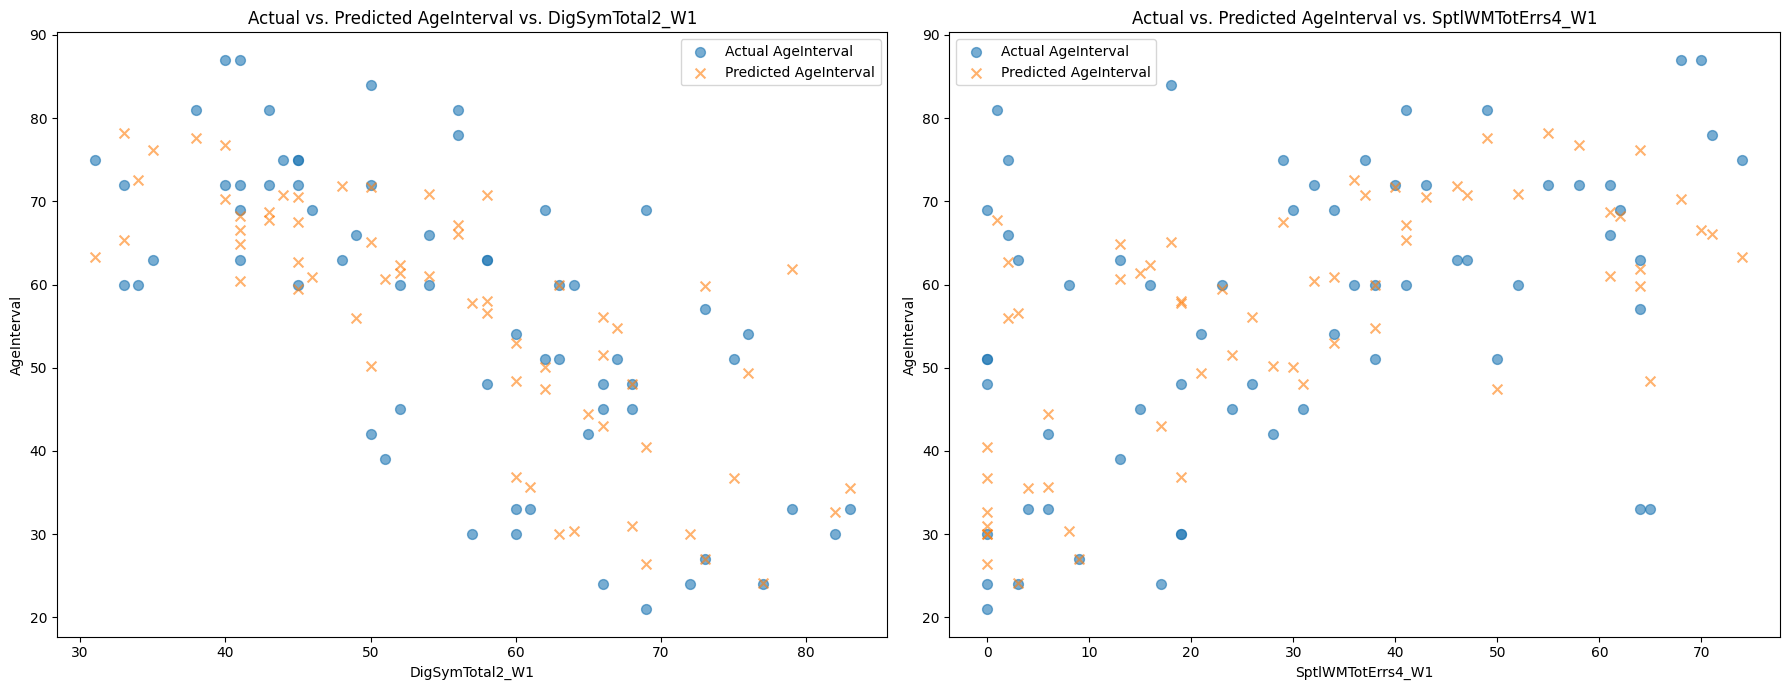

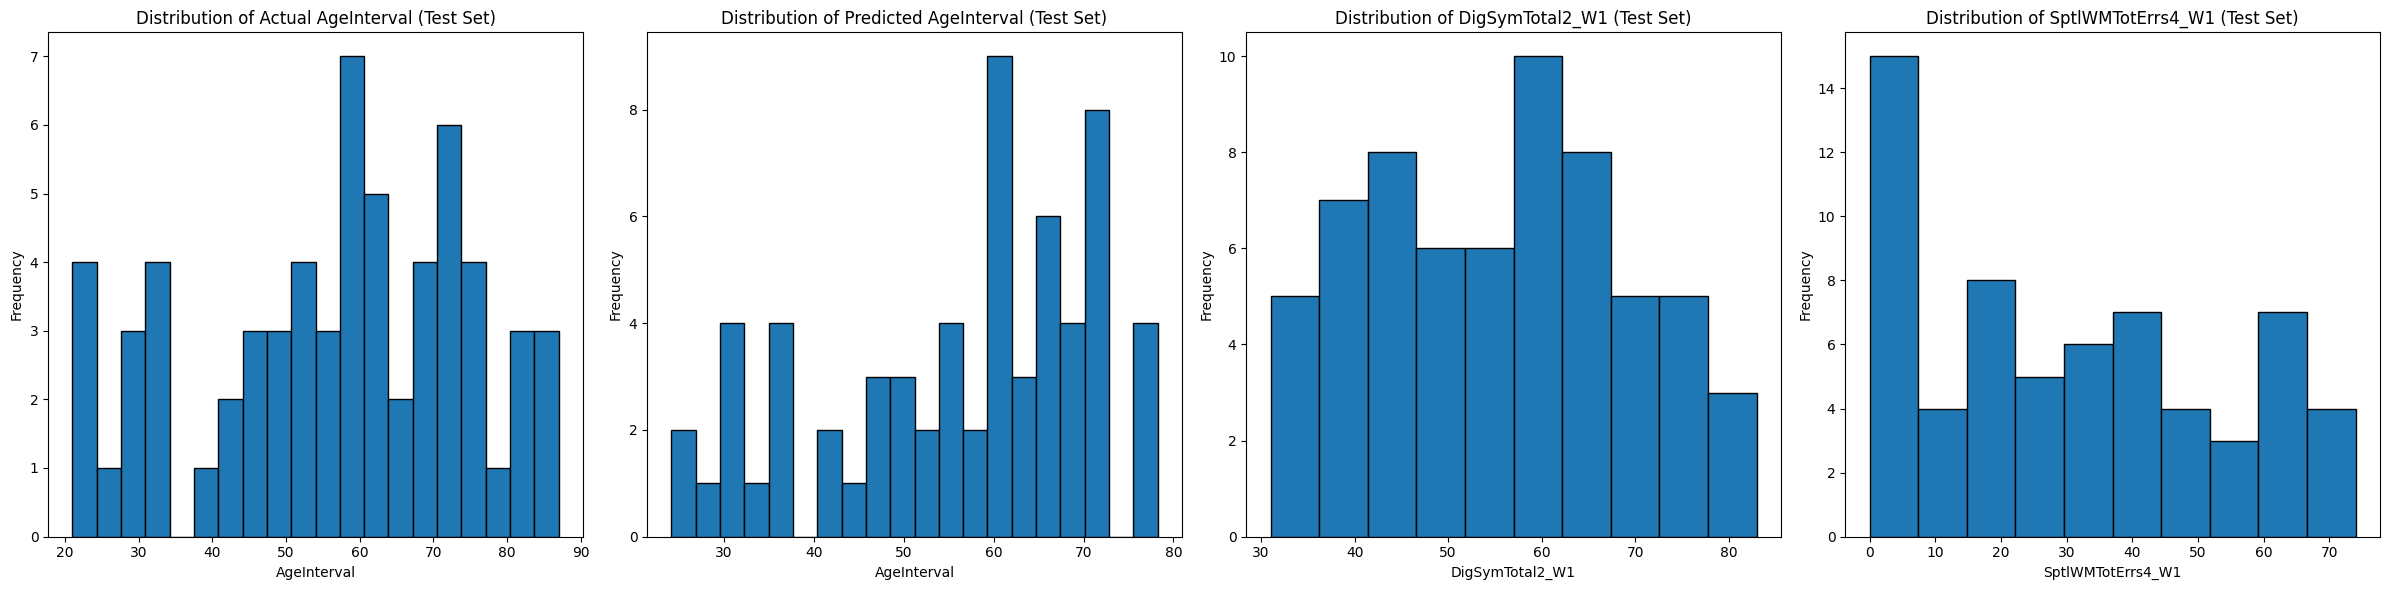

In [ ]:
# Feature importance analysis
feature_importances_regressor = pd.Series(random_forest_regressor_model.feature_importances_, index=X_train.columns)
feature_importances_regressor = feature_importances_regressor.sort_values(ascending=False)
top_2_features_regressor = feature_importances_regressor.head(2).index.tolist()

plt.figure(figsize=(10, 6))
feature_importances_regressor.plot(kind='bar')
plt.title('Random Forest Regressor Feature Importances for AgeInterval Prediction')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(f"\nTop 2 most important features for Regressor: {top_2_features_regressor}")

# Extra analysis for the best two features in the train set
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

axes[0].scatter(X_test[top_2_features_regressor[0]], y_test, alpha=0.6, label='Actual AgeInterval', s=50)
axes[0].scatter(X_test[top_2_features_regressor[0]], y_pred_regressor, alpha=0.6, label='Predicted AgeInterval', marker='x', s=50)
axes[0].set_title(f'Actual vs. Predicted AgeInterval vs. {top_2_features_regressor[0]}')
axes[0].set_xlabel(top_2_features_regressor[0])
axes[0].set_ylabel('AgeInterval')
axes[0].legend()

axes[1].scatter(X_test[top_2_features_regressor[1]], y_test, alpha=0.6, label='Actual AgeInterval', s=50)
axes[1].scatter(X_test[top_2_features_regressor[1]], y_pred_regressor, alpha=0.6, label='Predicted AgeInterval', marker='x', s=50)
axes[1].set_title(f'Actual vs. Predicted AgeInterval vs. {top_2_features_regressor[1]}')
axes[1].set_xlabel(top_2_features_regressor[1])
axes[1].set_ylabel('AgeInterval')
axes[1].legend()

plt.tight_layout()
plt.show()

# Histograms for actual age, predicted age, and top 2 features
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

axes[0].hist(y_test, bins=20, edgecolor='black')
axes[0].set_title('Distribution of Actual AgeInterval (Test Set)')
axes[0].set_xlabel('AgeInterval')
axes[0].set_ylabel('Frequency')

axes[1].hist(y_pred_regressor, bins=20, edgecolor='black')
axes[1].set_title('Distribution of Predicted AgeInterval (Test Set)')
axes[1].set_xlabel('AgeInterval')
axes[1].set_ylabel('Frequency')

feature1_name_hist = top_2_features_regressor[0]
axes[2].hist(X_test[feature1_name_hist], bins=10, edgecolor='black')
axes[2].set_title(f'Distribution of {feature1_name_hist} (Test Set)')
axes[2].set_xlabel(feature1_name_hist)
axes[2].set_ylabel('Frequency')

feature2_name_hist = top_2_features_regressor[1]
axes[3].hist(X_test[feature2_name_hist], bins=10, edgecolor='black')
axes[3].set_title(f'Distribution of {feature2_name_hist} (Test Set)')
axes[3].set_xlabel(feature2_name_hist)
axes[3].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


predictions_all_series_final = pd.Series(
    random_forest_regressor_model.predict(X_aligned),
    index=X_aligned.index
)


difference_all_series_final = predictions_all_series_final - y_aligned

df_merged_waves['Predicted_Age_All'] = np.nan
df_merged_waves['Predicted_Minus_Actual_Age_All'] = np.nan
df_merged_waves.loc[X_aligned.index, 'Predicted_Age_All'] = predictions_all_series_final
df_merged_waves.loc[X_aligned.index, 'Predicted_Minus_Actual_Age_All'] = difference_all_series_final